## Discrete Random Variables

Random Variables (RVs) represent quantities that depend on the outcome of a random experiment, and they are a convenient way of building probability models. Most realistic probability models are too complex to examine [analytically](https://en.wikipedia.org/wiki/Closed-form_expression#Analytic_expression), so we often rely on [computer simulations](https://en.wikipedia.org/wiki/Computer_simulation) of the random phenomenon at hand. But in order to simulate probability models, we must be able to [generate random numbers](https://en.wikipedia.org/wiki/Random_number_generation), i.e. realizations of RVs. In real life, we can generate random numbers by flipping coins, rolling dice, [measuring cosmic radiation](https://phys.org/news/2004-09-random-cosmic-rays.html), or some other unpredictable process. Below we look at how computers generate random numbers, and use them to confirm analytical results on discrete RVs. 


##### Pseudo-Random Numbers 

Computers are *deterministic* machines that cannot generate *truly* random numbers by running a program (although one can get better  numbers with appropriate [hardware](https://en.wikipedia.org/wiki/Hardware_random_number_generator)). But they can be programmed to efficiently generate sequences that, although deterministic, are highly irregular and unpredictable, i.e. you cannot figure out the next value by observing past ones. The values thus generated are called [pseudo](https://en.wikipedia.org/wiki/Pseudo-)-random numbers, and the programs are called [pseudo-random number generators (PRNG)](https://en.wikipedia.org/wiki/Pseudorandom_number_generator). The *pseudo* qualifier is frequently dropped even for numbers generated by a computer, which are not random in the probabilistic sense of the word.

##### Linear Congruence Generators 

Until recently, the most commonly used PRNGs were [Linear Congruential Generators (LCG)](https://en.wikipedia.org/wiki/Linear_congruential_generator). The idea behind these is very simple: you apply a *modulo* operation to a *linear recurrence*:
$x_{n+1} = (a \cdot x_n + c ) \mod m ; \quad \quad n \ge 0$
There are four parameters in a LCG: the *modulus* $m$, the *multiplier* $a$, the *increment* $c$, and the sequence's initial value $x_0$, called the *seed*. Obviously, all numbers produced this way are in $\{0,1,\ldots,m-1\}$, because they are remainders of division by $m$. Below is an example for specific values $m=100, a=17, c=45, x_0=39$.

In [224]:
m = 100; a = 17; c = 45; 
x = [0] * 25; x[0] = 39

for i in range( 1, len(x) ):
    x[i] = ( a * x[i-1] + c ) % m
print(x)

[39, 8, 81, 22, 19, 68, 1, 62, 99, 28, 21, 2, 79, 88, 41, 42, 59, 48, 61, 82, 39, 8, 81, 22, 19]


This generates a seemingly random sequence, but if you look more closely you can see that it repeats after revisiting the seed $x_0=x_{20}=39$. By construction, *all* LCG sequences (for any parameters) will repeat after some point, and the number of steps until they do so is called the *period length*. This is a result of modular arithmetic and the fact that the recurrence depends on only the last value: you can get at most $\# m $ distinct numbers from the $\mod m$ function, so by the [pigeonhole principle](https://en.wikipedia.org/wiki/Pigeonhole_principle) the seed will repeat after at most $m$ steps. Note that the period length of any LCG is bounded by $m$, but depending on the other parameters it can be smaller (e.g., with $m=100$ above, we got a period of $20$). Obviously we want a high period for our PRNG, which makes it necessary (but not sufficient) to have a high modulus. Besides long periods, we want the generated numbers to be *evenly* distributed and *irregular* (translated in probability as *uniform* and *independent*). Choosing good PRNGs is a whole research area in itself, and there are [tests](https://en.wikipedia.org/wiki/Randomness_test) to check the quality of "random" numbers. For example, the [RANDU](https://en.wikipedia.org/wiki/RANDU) LCG used in 1960's mainframes gave very regular 3D patterns like the one below in [spectal tests](https://en.wikipedia.org/wiki/Spectral_test)

<a title="The original uploader was Luis Sanchez at English Wikipedia., CC BY-SA 3.0 &lt;http://creativecommons.org/licenses/by-sa/3.0/&gt;, via Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Randu.png"><img width="512" alt="Randu" src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/38/Randu.png/512px-Randu.png"></a>
  
  

We can visually inspect the quality of a popular LCG specification in 1D ([histogram](https://en.wikipedia.org/wiki/Histogram)), 2D, and 3D ([scatterplots](https://en.wikipedia.org/wiki/Scatter_plot)); as desired, there are no discernible patterns in these plots below:

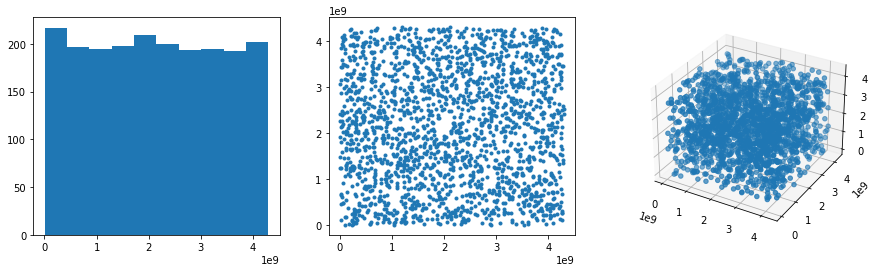

In [225]:
m = 2**32; a = 1664525; c = 1013904223 # parameters
x = [0] * 2000                         # initialize list 
x[0] = 123456789                       # set seed

for i in range( 1, len(x) ):
    x[i] = ( a * x[i-1] + c ) % m
    
import matplotlib.pyplot as plt 
plt.figure(figsize=(15, 4))

plt.subplot(1,3,1)
plt.hist(x)

plt.subplot(1,3,2)
plt.plot( x[1:len(x)], x[0:(len(x)-1)] , '.')

ax = plt.subplot(1,3,3, projection='3d')
ax.scatter3D( x[2:len(x)], x[1:(len(x)-1)], x[0:(len(x)-2)]);

plt.show()

##### PRNG in Python

We will not dig deeper into the gory details of PRNGs, but it is useful to know the basics. From now on we will just use default libraries which are vetted and good enough for most applications (unless you are working on cryptography or online gambling). Python's [```random```](https://docs.python.org/3/library/random.html) library uses the [Mersenne Twister](https://en.wikipedia.org/wiki/Mersenne_Twister), a variation on LCGs with better properties; e.g., it has a period length of $2^{19937}-1$ (for comparison, the number of particles in the known universe is $\sim 2^{268}$). The ```random``` library allows you to set the *seed* (if you don't, it uses the system time), which is useful for debugging code: simulations can and should give different results every time you run then, but if you fix the seed you can compare results between program runs. 

PRNGs generate uniformly distributed integers in some range $[0,m)$, but for applications we need random numbers from all sorts of distributions. To achieve this, we can *manipulate* the uniform pseudo-random numbers by appropriate transformations or algorithms. For example, if we need uniform integers in a different range $[0,k)$ where $k<m$, we can draw numbers in $[0,m)$ and only keep the ones that are $<m$; it is straightforward to prove that the *conditional* probabilities of the censored numbers will be uniform in $[0,k)$. If, on the other hand, we need uniform integers in a larger interval $[0,k),\quad k>m$, we can combine digits from several $[0,m)$ numbers: e.g. for uniform integers in $[0,100)$, we can use a random $\{0-9\}$ digit for the ones position, and another random $\{0-9\}$ digit for the tens position (Note that if you *add* uniformly distributed numbers, their sum will *not* be uniform). Using similar but much more efficient transformations, the ```random``` library can generate pseudo-random numbers from a range of standard distributions, as well as create pseudo-random permutations and samples from collections of objects, like lists. The following example generates 1000 uniform random integers in $\{0,1,\ldots,9\}$ using the ```randint``` function, and draws a barplot of their frequecies:


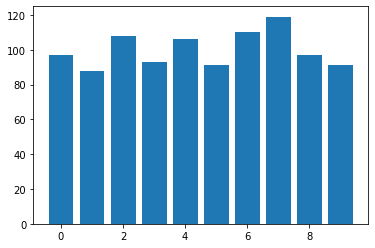

In [226]:
import random as rnd

rnd.seed(123456789)                # setting seed

rnd_digits = [None] * 1000         # initializing results list
for i in range(0,len(rnd_digits)):
    rnd_digits[i] = rnd.randint(0,9)

import collections   
counts = collections.Counter(rnd_digits)

plt.bar( counts.keys(), counts.values() )
plt.show()

##### Binomial Distribution

We now verify the Probability Mass Function (PMF) of the Binomial$(n,p)$ distribution:
$$ P(X=x) = \begin{cases} { n \choose x } p^x (1-p)^{n-x}, & x\in \{0,1,\ldots, n\} \\
0, & \textrm{o/w}
\end{cases}$$
This and other commmon PMFs are available in Python's [```scipy.stats```](https://docs.scipy.org/doc/scipy/reference/stats.html?highlight=stats#module-scipy.stats) module. 
The Binomial RV arrises as the # of successes in $n$ independent Bernoulli trials, all with the same probability of success $p$. The ```random.choices``` function can simulate any *finite* discrete RV, including Bernoulli trials for any $p$ (we could also generate Binomials directly using ```scipy.stats.binom.rvs```, but we want to illustrate how the transformation works). We represent "success" with $1$ and "failure" with $0$, which allows us to *sum* the results go get Binomial random numbers. The following code generates 1000 Binomial random *variates* (variate is another name for a realized value of a RV), and plots their relative frequency together with their theoretical PMF. 

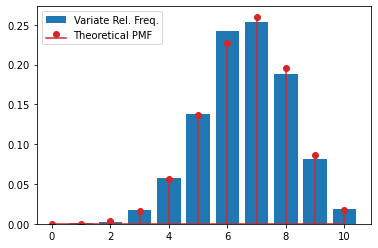

In [227]:
n = 10; p = 2/3        # Binomial parameters
x = [None] * 1000        

for i in range(0,len(x)):    
    x[i] = sum( rnd.choices( [1, 0], weights= [p, 1-p], k=n) ) 

counts = collections.Counter(x)  # Count variate frequencies 

import numpy as np
plt.bar( counts.keys(), np.array( list( counts.values() ) ) / len(x) ) # Barplot of relative frequencies 

from scipy.stats import binom    
plt.stem( np.arange(0,11), binom.pmf( np.arange(0,11), n, p), linefmt = 'C3-', markerfmt = 'C3o' ) # PMF plot
plt.legend(['Variate Rel. Freq.', 'Theoretical PMF'])
plt.show()

The simulated relative frequencies (barplot) are very close to the theoretical probabilities (PMF). This is not by coincidence, as it can be proved (see [Law of Large Numbers](https://en.wikipedia.org/wiki/Law_of_large_numbers)) that the relative frequencies will convergence to the theoretical probabilities as the number of variates increases.

Note that we could also simulate Binomial variates directly with ```scipy.stats.binom.rvs```:

In [228]:
binom.rvs(n, p, size=5)

array([7, 5, 7, 6, 8])

#####  Geometric Dsitribution

A Geometric RV has *infinite* range, so we cannot use Python's ```random.choices``` function to generate random variates. Nevertheless, we can generate variates using the definition of the Geometric distribution as the number of Bernoulli trials until the first success. In other words, we can simulate repeated Bernoulli trials until the first success, and measure how long it took. This is not the most efficient approach, especially for small $p$, but it verifies how the Geometric comes about. The following code generates $1000$ Geometric($p=1/3$) variates this way, and plots their frequency barplot against the corresponding Geometric PMF.


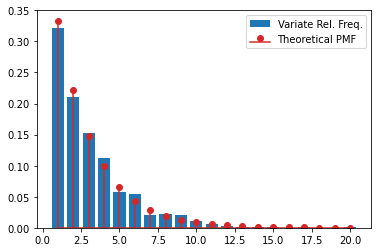

In [229]:
p = 1/3       # Geometric Parameter

x = [None] * 1000
for i in range(0,len(x)):
    j = 0; Bern = False  # initialize iteration
    while not Bern:
        j += 1           # Repeated Bernoulli trials until success
        Bern = rnd.choices( [True, False], weights= [p, 1-p]).pop()
    x[i] = j

counts = collections.Counter(x)  # Count variate frequencies 

import numpy as np
plt.bar( counts.keys(), np.array( list( counts.values() ) ) / len(x) ) # Barplot of relative frequencies 

from scipy.stats import geom    
plt.stem( np.arange( 1, max(x)+1 ), geom.pmf( np.arange(1,max(x)+1), p), linefmt = 'C3-', markerfmt = 'C3o' ) # PMF plot
plt.legend(['Variate Rel. Freq.', 'Theoretical PMF'])
plt.show()

### Problems

1. Show (analytically) that if you take the PMF of a discrete uniform RV $X$ in $[0,m)$ and condition on it being *less than* $k$, with $k<m$, then the resulting conditional distribution will be uniform in $[0,k)$.
2. Use a simulation experiment to verify that the *sum* of two discrete uniform RVs in $[0,10]$ is *not* uniformly distributed in $[0,20]$, by generating $1000$ variates of the sum and plotting their relative frequency.
3. Use a simulation experiment to verify the [memoryless property](https://en.wikipedia.org/wiki/Memorylessness) of the Geometric distribution. More specifically, generate 2000 random variates from the Geometric($1/2$) distribution using ```scipy.stats.geom.rvs```, and keep the values that are greater or equal to $3$, effectively conditioning on $X\ge 3$. Create a relative frequency plot of the *excess* values, i.e. the original values minus 2, and compare them to the theoretical Geometric($1/2$) PMF.

<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.